In [ ]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

In [ ]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

In [ ]:
print len(scenes_dataset_yaml)

In [ ]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=5,
    base_environment_type="planar_tabletop")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=5,
    base_environment_type="planar_tabletop")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

In [ ]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/planar_tabletop_lines/realproj_context" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_lines_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.01, 'betas': [0.9, 0.99], 'weight_decay': 1E-5},
      "step_size": 200,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(1000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=500) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=500) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if i > 300 and cycles_since_improvement > 100:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))
print "Done"

In [ ]:
cycles_since_improvement = 0
scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.0001, 'betas': [0.9, 0.99]},
      "step_size": 50,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
for i in range(2000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=100) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=100) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 200:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 10 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

('Model evaluated on all of test: ', 2.629136645442359)


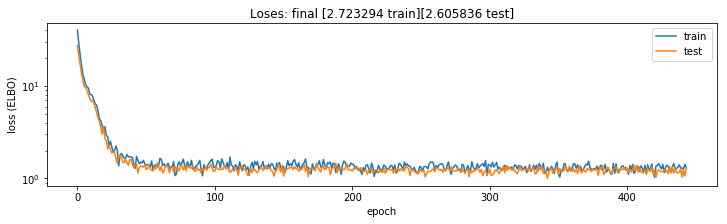

In [6]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:])))
print("Model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

In [ ]:
# Save model
pre_param_settings = {}
for name in pyro.get_param_store().get_all_param_names():
    pre_param_settings[name] = pyro.param(name).clone()

pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_lines_without_projection.pyro")
#pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

In [19]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_lines_without_projection.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

print(model.class_flows[1][4].arn)
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

('Loaded model evaluated on all of test: ', -4.668928621921079)
AutoRegressiveNN(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=25, out_features=50, bias=True)
    (1): Dropout(p=0.0)
    (2): MaskedLinear(in_features=50, out_features=50, bias=True)
    (3): Dropout(p=0.0)
    (4): MaskedLinear(in_features=50, out_features=10, bias=True)
  )
  (f): ReLU()
)


Parameter containing:
tensor([-0.0415, -0.0772, -0.0823, -0.2127, -0.0596, -0.0806,  0.1647,  0.1229,
        -0.1603, -0.0470,  0.0966, -0.1213,  0.0910, -0.1325,  0.0401,  0.1522,
         0.0407,  0.0333,  0.0283,  0.1501, -0.1317, -0.1960,  0.1875, -0.1000,
        -0.1718, -0.0408,  0.2298, -0.0392,  0.2295,  0.1918, -0.0321,  0.0790,
        -0.1535, -0.2385,  0.0766, -0.1195, -0.0547, -0.0185,  0.1233, -0.1166,
         0.0180, -0.1522,  0.0057,  0.1231, -0.0708, -0.0854,  0.1250,  0.1599,
        -0.1705, -0.2381], requires_grad=True)

In [ ]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

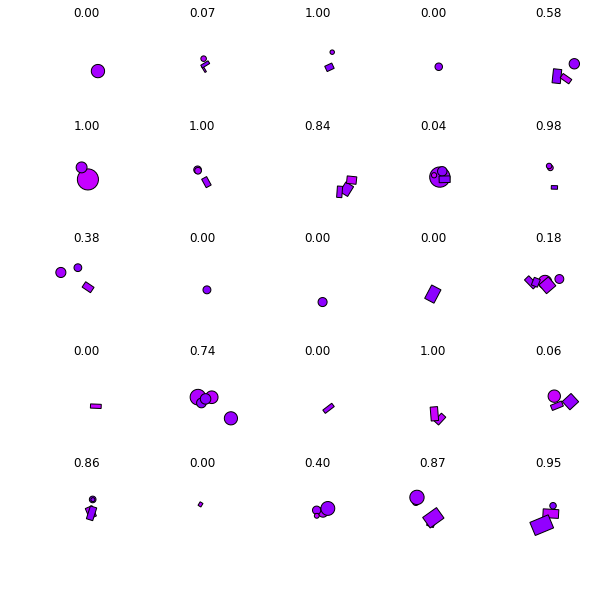

In [21]:
# Convert that data back to a YAML environment, which is easier to
# handle.
import scipy.stats
side_width = 5
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scene_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "planar_tabletop", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        plt.gca().set_title("%2.2f" % rvalue**2)

[4, 4, 1, 4, 5, 4, 1, 2, 1, 1, 2, 4, 3, 5, 3, 5, 2, 1, 2, 4, 4, 3, 1, 2, 3, 3, 4, 2, 3, 2, 4, 4, 2, 4, 3, 1, 4, 5, 4, 1, 4, 1, 1, 2, 4, 4, 2, 5, 2, 2, 4, 4, 1, 4, 4, 1, 5, 1, 4, 1, 2, 4, 3, 4, 5, 4, 5, 3, 3, 2, 3, 4, 5, 1, 3, 2, 3, 1, 4, 5, 2, 3, 5, 5, 2, 1, 4, 4, 2, 5, 4, 1, 2, 1, 3, 5, 5, 3, 1, 2, 4, 4, 4, 3, 4, 1, 2, 5, 5, 1, 1, 4, 4, 4, 3, 3, 1, 2, 1, 1, 5, 5, 5, 2, 2, 5, 2, 1, 3, 3, 2, 2, 3, 4, 4, 5, 2, 3, 1, 5, 2, 5, 2, 1, 5, 4, 2, 1, 4, 4, 4, 1, 2, 3, 2, 4, 4, 3, 5, 4, 1, 4, 5, 5, 5, 4, 2, 1, 3, 1, 3, 3, 5, 5, 5, 4, 2, 1, 5, 4, 1, 4, 5, 2, 4, 2, 1, 3, 4, 5, 4, 4, 1, 1, 3, 1, 4, 3, 3, 2, 5, 5, 4, 1, 4, 4, 2, 3, 2, 3, 3, 4, 2, 2, 1, 2, 2, 1, 5, 3, 4, 2, 4, 3, 1, 4, 4, 2, 5, 4, 2, 4, 3, 2, 5, 2, 2, 4, 2, 4, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 3, 2, 3, 1, 2, 1, 2, 3, 4, 1, 5, 5, 2, 5, 3, 3, 5, 4, 1, 4, 3, 1, 2, 4, 2, 4, 5, 2, 4, 5, 1, 5, 4, 1, 4, 2, 4, 3, 3, 5, 1, 1, 3, 5, 3, 2, 4, 5, 3, 5, 1, 5, 4, 2, 4, 1, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 1, 2, 1, 4, 1, 2, 4, 4, 2, 1, 3, 3, 4, 2, 1, 5, 5, 

Text(0,0.5,'Count')

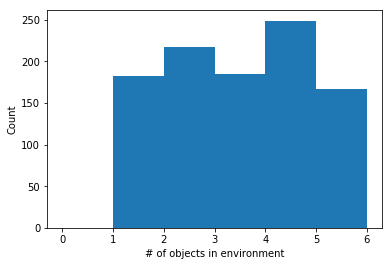

In [20]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    [generated_n_objs.append(scene["n_objects"]) for scene in scene_yaml]
print generated_n_objs
plt.hist(generated_n_objs, bins=range(7))
plt.xlabel("# of objects in environment")
plt.ylabel("Count")

In [23]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

# Generate some examples
scene_yaml = []
for k in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
params_by_object_class_nonpen = generate_params_by_object_class(scene_yaml)

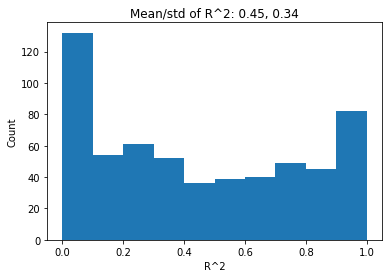

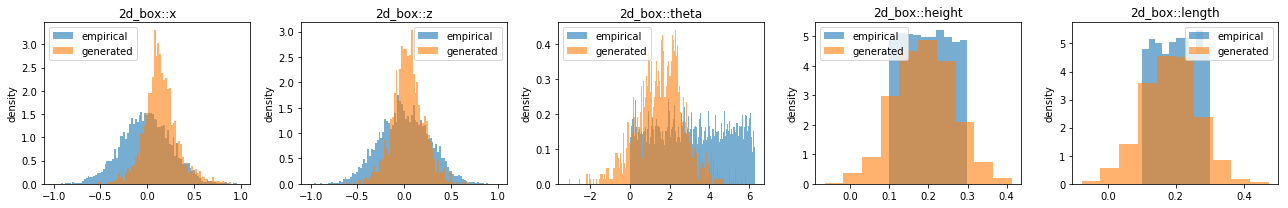

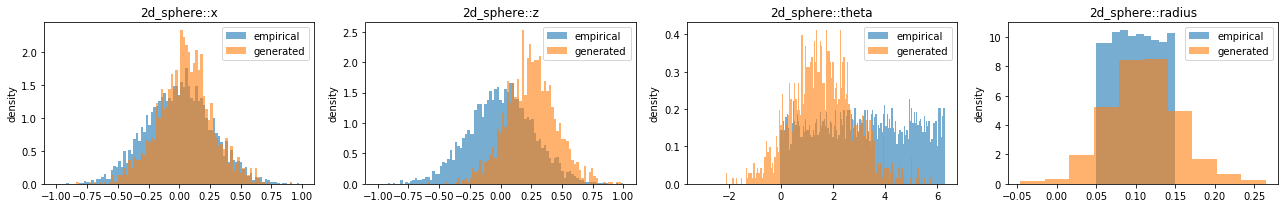

In [24]:
# Measure colinearity by doing a linear fit and reporting the error
import scipy.stats
rsquares = []
for scene in scene_yaml:
    if (scene["n_objects"] > 2):
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        rsquares.append(rvalue**2.)
plt.figure()
plt.hist(rsquares)
plt.ylabel("Count")
plt.xlabel("R^2")
plt.title("Mean/std of R^2: %2.2f, %2.2f" % (np.mean(rsquares), np.std(rsquares)))

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        params_by_object_class_nonpen[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "generated"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()

In [ ]:
# EXPORT
for k in range(50):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
    
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

for env in scene_yaml:
    env_name = "env_%d" % int(round(time.time() * 1000))
    with open("generated_tabletop_lines_scenes_without_context_with_projection.yaml", "a") as file:
        yaml.dump({env_name:
                   env}, file, Dumper=noalias_dumper)

In [ ]:
# Probe what the guide is doing by, for a few test data examples,
from copy import deepcopy
subsample_inds = np.random.permutation(data_test.batch_size)
plt.figure().set_size_inches(10, 10)
N_examples = 5
for k in range(N_examples):
    plt.subplot(2, N_examples, k+1)
    data_test_subsample = data_test.subsample([subsample_inds[k]])
    generated_env = deepcopy(data_test_subsample.convert_to_yaml()[0])
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("BEFORE INV PROJ %d" % k)
    plt.subplot(2, N_examples, N_examples+k+1)
    for object_i in range(generated_env["n_objects"]):
        obj_yaml = generated_env["obj_%04d" % object_i]
        class_i = data_test_subsample.dataset.class_name_to_id[obj_yaml["class"]]
        new_params = model.class_guides[class_i](data_test_subsample.params_by_class[class_i][:, object_i, :])
        obj_yaml["pose"] = new_params[0, :3]
        obj_yaml["params"] = new_params[0, 3:]
    dataset_utils.DrawYamlEnvironmentPlanar(generated_env, "planar_tabletop", ax=plt.gca())
    plt.gca().set_title("AFTER INV PROJ %d" % k)